# Mix the best and the second best in the sample.

* It uses the center merge strategy.
* Primitives: ['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity']
* [Kaggle Run](https://www.kaggle.com/code/naresh/amoebanet?scriptVersionId=112421872)
* Best Accuracy: 79.49%
* Best Configuration:

|Block|Normal|Reduction|
|:-:|-|-|
|1.|`[0, 0, 5, 1, 0]`|`[1, 1, 0, 4, 0]`|
|2.|`[0, 1, 3, 1, 0]`|`[1, 1, 0, 4, 0]`|
|3.|`[1, 0, 2, 4, 1]`|`[0, 0, 2, 5, 1]`|
|4.|`[1, 1, 0, 4, 0]`|`[1, 1, 0, 4, 0]`|
|5.|`[1, 1, 0, 4, 0]`|`[1, 1, 1, 2, 1]`|
||||

<!--
data = [
  [
    [0, 0, 5, 1, 0],
    [0, 1, 3, 1, 0],
    [1, 0, 2, 4, 1],
    [1, 1, 0, 4, 0],
    [1, 1, 0, 4, 0]
  ],
  [
    [1, 1, 0, 4, 0],
    [1, 1, 0, 4, 0],
    [0, 0, 2, 5, 1],
    [1, 1, 0, 4, 0],
    [1, 1, 1, 2, 1]
  ]
]

normal, reduction = data
for b_id in range(len(normal)):
  fmt = '|{}.|`[{}, {}, {}, {}, {}]`|`[{}, {}, {}, {}, {}]`|'
  print(fmt.format(b_id+1, *normal[b_id], *reduction[b_id]))
-->

<br>
<section>
  <h2>Best Cell</h2>
  <img src='amoeba.v4.best.cells.png'>
</section>

## Installation

In [1]:
%%capture
# !pip install mplcursors
# !pip install -q git+https://github.com/EfficientDL/codelab_utils.git

## Import Modules used in this Notebook

In [1]:
%%capture
import random
import seaborn

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import codelab_utils.mpl_styles as mpl_styles
import networkx as nx

from tensorflow.keras import layers, losses, models, optimizers
from matplotlib import pyplot as plt
from matplotlib import ticker
from collections import deque
from random import sample, shuffle, randrange
from math import floor
from functools import reduce

SEED = 111

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

## Dataset Setup

In [3]:
%%capture
# DATASET = 'mnist'
DATASET = 'cifar10'

if DATASET == 'mnist':
    DATASET_PARAMS = dict(
        input_shape=(28, 28, 3),
        n_classes=10,
        baseline_accuracy=.3,
        train_batch_size=128
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

    gray_to_rgb = lambda image, label: (tf.repeat(image, 3, axis=-1), label)
    train_ds = train_ds.map(gray_to_rgb)
    val_ds = val_ds.map(gray_to_rgb)
elif DATASET == 'cifar10':
    DATASET_PARAMS = dict(
        input_shape=(32, 32, 3),
        n_classes=10,
        baseline_accuracy=.1,
        train_batch_size=128
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

# Hack to run on Kaggle
TDS = train_ds.shuffle(
    500,
    reshuffle_each_iteration=True
).batch(DATASET_PARAMS['train_batch_size'])
VDS = val_ds.batch(256)

for item in TDS: pass
for item in VDS: pass

2022-11-29 09:38:29.715459: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2022-11-29 09:38:49.349351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 09:38:49.472560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 09:38:49.473351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

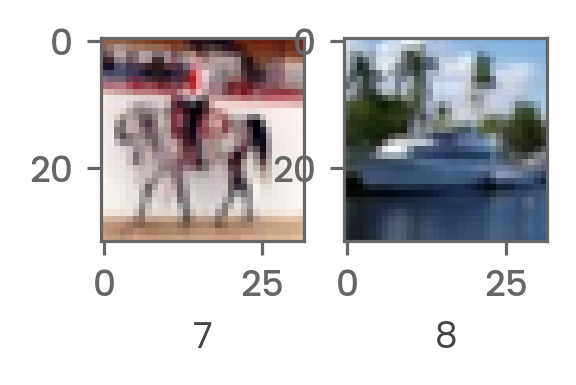

In [4]:
def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, item in enumerate(display_list):
        image, label = item
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))
        axis.set_xlabel(label)

items = []
for item in train_ds.take(2).as_numpy_iterator():
    items.append(item)

display(items, size=(2,2))

## Architecture Search

In [5]:
CHILD_PARAMS = dict(
    epochs=7,
    batch_size=DATASET_PARAMS['train_batch_size'],
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    max_branch_length=2,
    blocks=5,
    cells=2,
    initial_width=1,
    initial_channels=4
)

STATE_SPACE = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]
BLOCK_TIMESTEPS = 5

TDS = CHILD_PARAMS['train_ds'].shuffle(
    500,
    reshuffle_each_iteration=True
).batch(CHILD_PARAMS['batch_size'])
VDS = CHILD_PARAMS['val_ds'].batch(256)

class CNNCell():
    """
    It composes a cell based on the input configuration.
    Arguments:
        stride: A positive integer to represent the convolution strides.
            Normal cells use stride=1 and reduction cells use stride=2
    """
    def __init__(self, stride=1, channels=64):
        self.channels = channels
        self.stride = stride
        self.kwargs = dict(strides=(1, 1), padding='same')
    
    def repair_channels(self, inp):
        """
        This method sends the input through a convolution layer with
        a fixed channel size to ensure that the inputs to each cell block
        have identical channel dimensions.
        """
        return layers.Conv2D(self.channels, 1, padding='same')(inp)

    def repair_branches(self, branches):
        """
        It transforms the input branches to an identical feature space.
        It is useful when a cell receives inputs with different feature spaces.
        """
        (hidden_1, width_1), (hidden_2, width_2) = branches

        if width_1 != width_2:
            hidden_1 = layers.Conv2D(
                self.channels,
                3,
                strides=(2,2),
                padding='same'
            )(hidden_1)
        else:
            hidden_1 = self.repair_channels(hidden_1)
        
        hidden_2 = self.repair_channels(hidden_2)
        
        return [hidden_1, hidden_2]
    
    def reduce_inputs(self, inputs):
        """
        It halves the input feature space using a convolution layer with stride 2
        """
        if self.stride == 2:
            inputs = list(
                map(
                    lambda inp: layers.Conv2D(
                        self.channels,
                        3,
                        strides=(2,2),
                        padding='same'
                    )(inp),
                    inputs
                )
            )
        
        return inputs
    
    def apply_op(self, op_id, inp):
        """
        It applies a primitive operation to the input.
        """
        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **self.kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **self.kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **self.kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **self.kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **self.kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
        """
        It applies a combination operation to the inputs.
        """
        if op_id == 0:
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_1, input_2 = list(map(lambda idx: inputs[idx], block_config[:2]))
        op1, op2 = block_config[2:4]
        combine_op = block_config[-1]

        output = self.combination(
            combine_op,
            self.apply_op(op1, input_1),
            self.apply_op(op2, input_2)
        )

        return output

    def make_cell(self, cell_config, branches):
        """
        It constructs a cell based on the cell_config and the branches.
        A cell_config is 2-D numpy array of shape [5,5] which contains
        the 5 state choices for each of the 5 blocks.
        """
        inputs = self.repair_branches(branches)
        inputs = self.reduce_inputs(inputs)

        blocks = []
        for block in cell_config:
            block_output = self.compose_block(block, inputs)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        output = self.repair_channels(x)

        return output

class ParentSelectionStrategies(object):
    def __init__(self, child_params) -> None:
        self.elementary_strategies = [
            'best',
            'best_and_random',
            'top_two',
        ]
        self.strategies = {
            'best': self.best,
            'best_and_random': self.best_and_random,
            'top_two': self.top_two,
        }
        self.child_params = child_params
    
    def best_and_random(self, num_candidates):
        best_parent = num_candidates - 1
        random_parent = random.randrange(num_candidates-1)

        return [best_parent, random_parent]
    
    def top_two(self, num_candidates):
        return [num_candidates-1, num_candidates-2]
    
    def best(self, num_candidates):
        best_parent = num_candidates - 1
        return [best_parent, best_parent]
    
    def get(self, name='best_and_random'):
        return self.strategies[name]

class MutationStrategies(object):
    def __init__(self, child_params) -> None:
        self.child_params = child_params
        self.elementary_strategies = ['point', 'block_swap']
        self.strategies = {
            'point': self.point,
            'block_swap': self.block_swap,
            'mixed': self.mixed,
            'gene_shuffle': self.gene_shuffle,
        }
    
    def point(self, config):
        address_shape = [self.child_params['blocks'], BLOCK_TIMESTEPS]
        mutation_address = tuple(map(randrange, address_shape))
        state_id = mutation_address[-1]
        state_space_id = STATE_ID_TO_STATE_SPACE_ID[state_id]
        mutation = randrange(len(STATE_SPACE[state_space_id]['values']))

        config[mutation_address] = mutation

        return config
    
    def block_swap(self, config):
        coordinates = list(map(
            randrange, [self.child_params['blocks']]*2
        ))
        config[coordinates] = config[list(reversed(coordinates))]

        return config
    
    def mixed(self, config):
        strategy_id = randrange(len(self.elementary_strategies))
        
        return self.strategies[self.elementary_strategies[strategy_id]](config)
    
    def gene_shuffle(self, config):
        blocks = config.shape[0]
        block_indices = list(range(blocks))
        random.shuffle(block_indices)

        # Select Genes
        selected = config[block_indices[:self.child_params['blocks']]]
        return selected

    def get(self, name='point'):
        return self.strategies[name]

class MergeStrategies(object):
    def __init__(self, child_params, mix_strategy) -> None:
        self.elementary_strategies = [
            'pick_first',
            'mix_two',
            'center_merge'
        ]
        self.strategies = {
            'pick_first': self.pick_first,
            'mix_two': self.mix_two,
            'center_merge': self.center_merge
        }
        self.mix_strategy = mix_strategy
        self.child_params = child_params
    
    def pick_first(self, *parents):
        return parents[0]

    def mix_two(self, *parents):
        first, second = parents
        return np.array(list(
            map(
                lambda c: self.mix_strategy(np.concatenate(c)),
                zip(first, second)
            )
        ))
    
    def center_merge(self, *parents):
        first, second = parents
        min_parent_contribution = self.child_params['blocks']//2
        extra_parent_contribution = self.child_params['blocks'] - (min_parent_contribution*2)
        merge_point = 2+int(random.random()+0.5)

        return np.array(list(
            map(
                lambda c: np.concatenate([c[0][:merge_point], c[1][merge_point:]]),
                zip(first, second)
            )
        ))

    def get(self, name='pick_first'):
        return self.strategies[name]

class Child(object):
    def __init__(self, config, train=True):
        self.config = config
        self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]
        self.model = self.make_child()
        self.accuracy = 0.0
        self.accuracy = self.train() if train else 0
        print('Child: {} \n Accuracy: {:1.4f}'.format(
            self.config,
            self.accuracy
        ))
    
    def make_child(self):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        width = CHILD_PARAMS['initial_width']
        branches = deque(maxlen=CHILD_PARAMS['max_branch_length'])
        branches.append((x, width))
        branches.append((x, width))

        for cell_type, stride in self.layers:
            width *= stride
            cnn_cell = CNNCell(
                stride,
                channels=CHILD_PARAMS['initial_channels']**width
            )

            x = cnn_cell.make_cell(self.config[cell_type], branches)
            branches.append((x, width))

        x = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        # model.summary()

        return model

    def train(self):
        history = self.model.fit(
            TDS,
            validation_data=VDS,
            epochs=CHILD_PARAMS['epochs']
        )
        self.accuracy = max(history.history['val_accuracy'])

        return self.accuracy

controller_params = dict(
    episodes=100,
    population_size=20,
    sample_size=12,
    max_mutations=2,
    mutation_strategy='mixed',
    merge_strategy='center_merge',
    parent_selection_strategy='top_two',
)

CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

TIMESTEP_ADDRESS_SPACE = (
    CHILD_PARAMS['cells'],
    CHILD_PARAMS['blocks'],
    len(STATE_ID_TO_STATE_SPACE_ID)
)
TIMESTEP_ADDRESSES = np.stack(
    np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
    -1
)

STATE_ADDRESSES = list(map(
    lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
    TIMESTEP_ADDRESSES
))

class Controller():
    def __init__(self, params, child_params):
        self.population_size = params['population_size']
        self.population = deque(maxlen=self.population_size)
        self.histories = []
        self.sample_size = params['sample_size']
        self.best_accuracies = []
        self.best_children = []
        self.params = params
        self.mutation_strategies = MutationStrategies(child_params)
        self.mutation_strategy = self.mutation_strategies.get(
            self.params['mutation_strategy']
        )
        self.merge_strategies = MergeStrategies(
            child_params,
            self.mutation_strategies.get('gene_shuffle')
        )
        self.merge_strategy = self.merge_strategies.get(
            self.params['merge_strategy']
        )
        self.parent_selection_strategies = ParentSelectionStrategies(child_params)
        self.parent_selection_strategy = self.parent_selection_strategies.get(
            self.params['parent_selection_strategy']
        )
    
    def random_state(self, address):
        (_, __, state_id) = address
        return randrange(len(STATE_SPACE[state_id]['values']))

    def create_random_child(self):
        state = list(map(self.random_state, STATE_ADDRESSES))
        config = np.array(state).reshape(TIMESTEP_ADDRESS_SPACE)
        child = Child(config)
        return child

    def initialize_population(self):
        """
        It creates children as specified through the size parameter.
        Each child is trained and their history is stored.
        It should be called only once.

        Arguments:
            size: The size of the population.
        """
        def work_fn():
            self.population.extend(map(
                lambda _: self.create_random_child(),
                range(self.sample_size)
            ))
            self.histories += self.population
        
        work_fn() if not self.population else None
    
    def mutate(self, config):
        def mutate_cell(cell_config):
            return reduce(
                lambda c,_: self.mutation_strategy(c),
                range(self.params['max_mutations']),
                cell_config
            )

        mutated_config = np.array(list(
            map(mutate_cell, config.copy())
        ))

        return mutated_config
    
    def choose_parents(self):
        p_sample = sample(range(len(self.population)), self.sample_size)
        sample_accuracies = list(map(
            lambda idx: self.population[idx].accuracy,
            p_sample
        ))
        ordered_sample = np.argsort(sample_accuracies)
        parent_ids = self.parent_selection_strategy(len(p_sample))
        sample_ids = list(map(
            lambda p_id: ordered_sample[p_id],
            parent_ids
        ))
        population_ids = list(map(lambda s_id: p_sample[s_id], sample_ids))
        parents = list(map(lambda p_id: self.population[p_id], population_ids))

        return parents
    
    def record_best(self):
        # Record the best accuracies
        population_accuracies = list(map(
            lambda item: item.accuracy,
            self.population
        ))

        self.best_accuracies.append(max(population_accuracies))
        self.best_children.append(np.argmax(population_accuracies))
    
    def update_population(self, child):
        if len(self.population) == self.population_size:
            print('Removal Candidate: {}\n Accuracy: {:1.5f}'.format(
                self.population[0].config,
                self.population[0].accuracy
            ))

        self.population.append(child)
    
    def reproduce(self, *parents):
        first, second = parents
        merged_config = self.merge_strategy(
            first.config,
            second.config
        )
        mutated_config = self.mutate(merged_config)
        child = Child(mutated_config)

        return child
    
    """How to send sorted configs to parent selection strategy?"""
    def run_cycle(self):
        # Pick parents
        first, second = self.choose_parents()
        print('First Parent: {}\n Accuracy: {:1.5f}'.format(
            first.config,
            first.accuracy
        ))
        print('Second Parent: {}\n Accuracy: {:1.5f}'.format(
            second.config,
            second.accuracy
        ))

        # Reproduce
        mutated_child = self.reproduce(first, second)

        # Update population
        self.update_population(mutated_child)

        # Record best children
        self.record_best()

        # Add the mutated child to the histories
        self.histories.append(mutated_child)

controller = Controller(controller_params, CHILD_PARAMS)
controller.initialize_population()

for episode in range(controller_params['episodes']):
    print('Cycle: ', episode)
    controller.run_cycle()

Epoch 1/7


2022-11-29 09:40:23.178994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 35s 83ms/step - loss: 2.0208 - accuracy: 0.2921 - val_loss: 1.6998 - val_accuracy: 0.3753
Epoch 2/7
313/313 [==============================] - 26s 82ms/step - loss: 1.5659 - accuracy: 0.4293 - val_loss: 1.4623 - val_accuracy: 0.4593
Epoch 3/7
313/313 [==============================] - 25s 81ms/step - loss: 1.3758 - accuracy: 0.5100 - val_loss: 1.3130 - val_accuracy: 0.5305
Epoch 4/7
313/313 [==============================] - 25s 81ms/step - loss: 1.2460 - accuracy: 0.5627 - val_loss: 1.1380 - val_accuracy: 0.5993
Epoch 5/7
313/313 [==============================] - 25s 81ms/step - loss: 1.1447 - accuracy: 0.6001 - val_loss: 1.0696 - val_accuracy: 0.6356
Epoch 6/7
313/313 [==============================] - 25s 81ms/step - loss: 1.0741 - accuracy: 0.6257 - val_loss: 1.0005 - val_accuracy: 0.6485
Epoch 7/7
313/313 [==============================] - 25s 81ms/step - loss: 1.0070 - accuracy: 0.6500 - val_loss: 0.9324 - val_accuracy: 0.6802
Child: [[

## Training Metrics

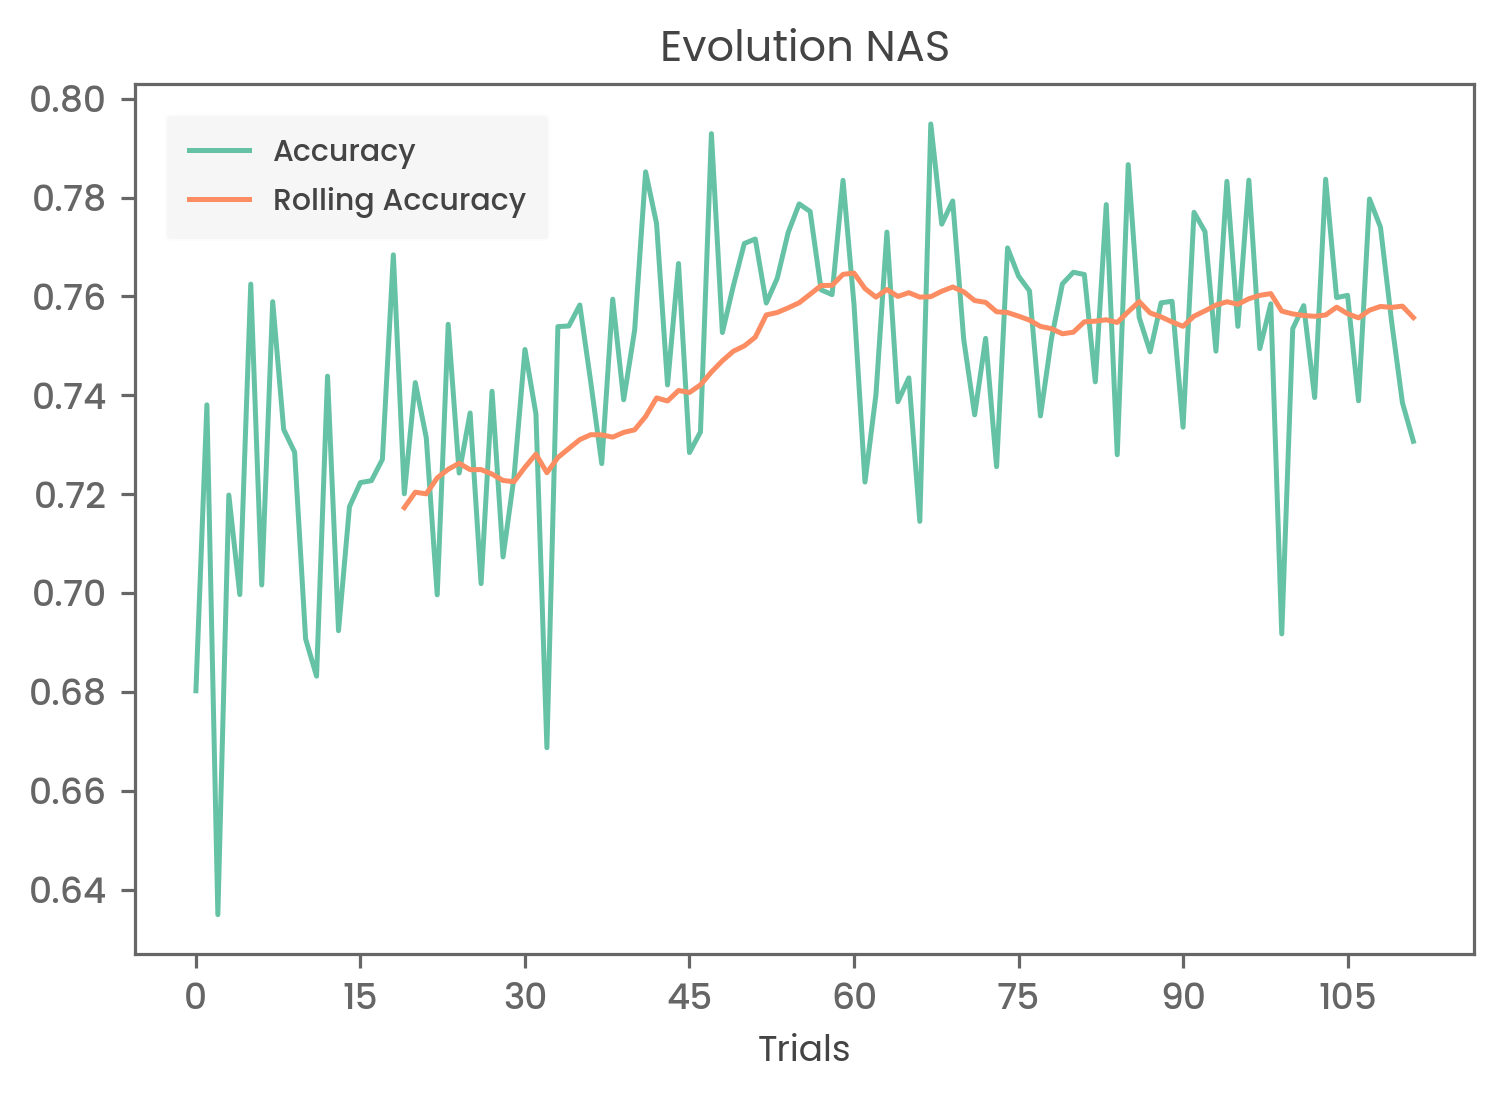

In [6]:
accuracies = list(map(lambda child: child.accuracy, controller.histories))
accuracies_df = pd.DataFrame(accuracies)
rolling_accuracies = accuracies_df.rolling(len(controller.population)).mean()[0].tolist()

plt.plot(accuracies, label='Accuracy')
axes = plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Trials')
plt.legend()
plt.title('Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

## Performance Analysis

([0.762499988079071,
  0.762499988079071,
  0.762499988079071,
  0.762499988079071,
  0.762499988079071,
  0.762499988079071,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7684249877929688,
  0.7594500184059143,
  0.7594500184059143,
  0.7594500184059143,
  0.785224974155426,
  0.785224974155426,
  0.785224974155426,
  0.785224974155426,
  0.785224974155426,
  0.785224974155426,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,
  0.7929499745368958,


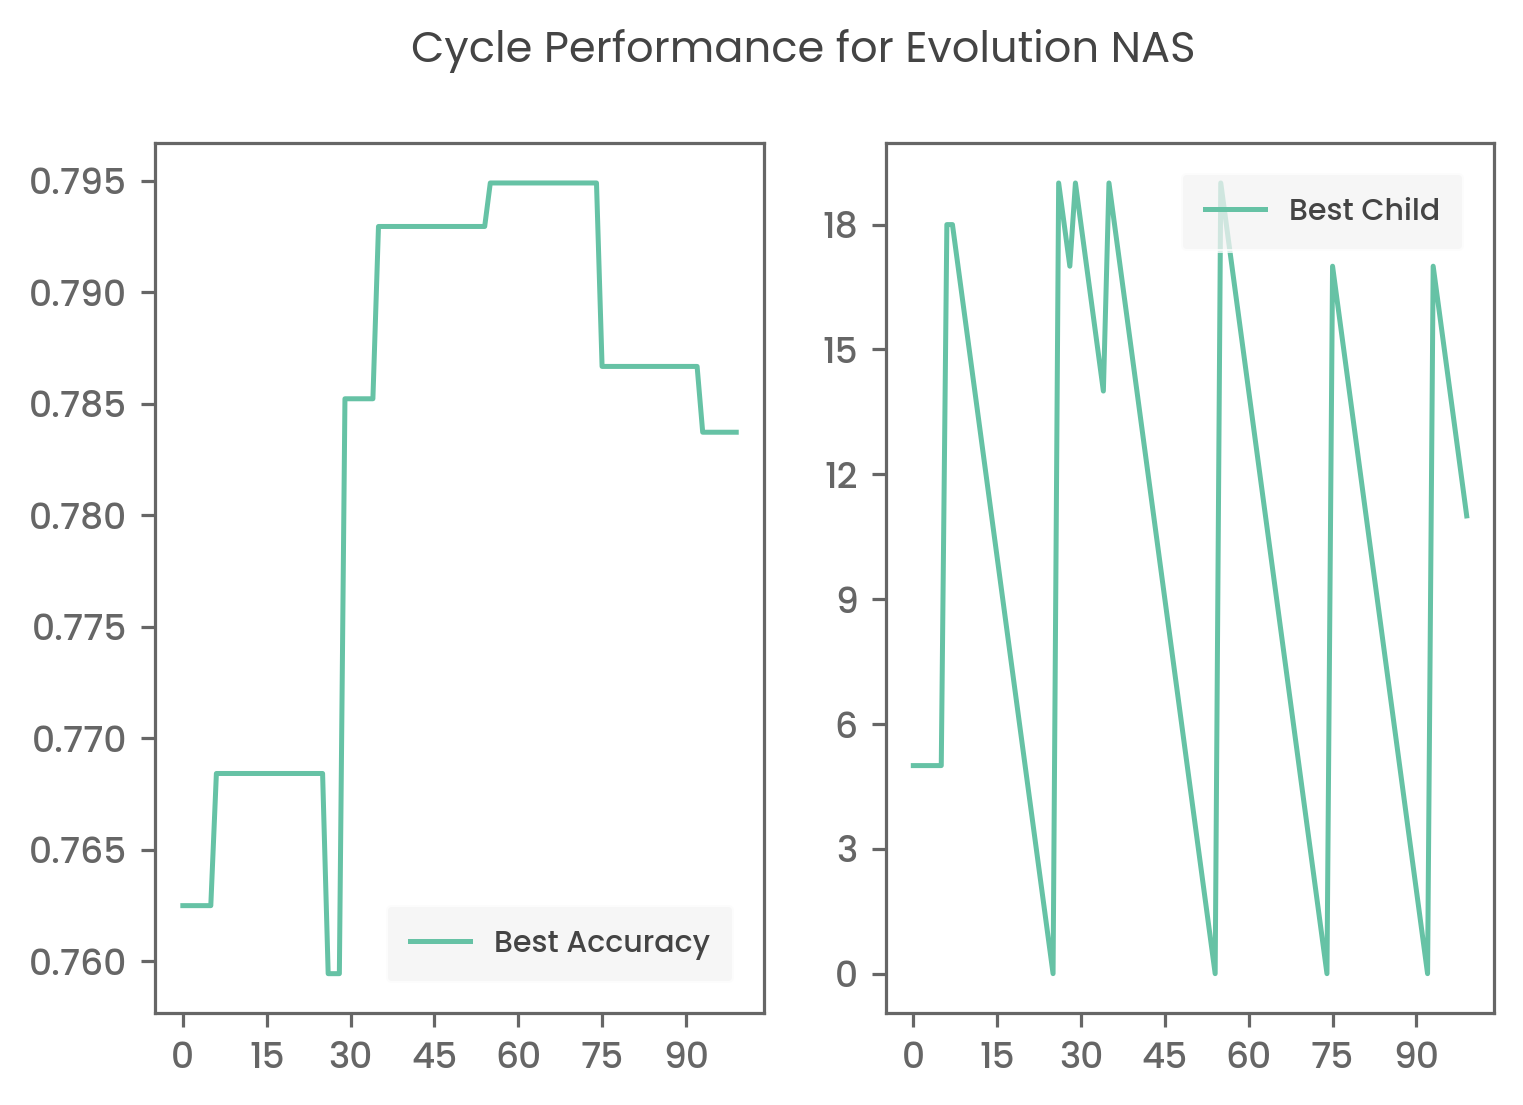

In [7]:
fig, axes = plt.subplots(1, 2)
ax_acc, ax_child = axes

ax_acc.plot(controller.best_accuracies, label='Best Accuracy')
ax_acc.legend()
ax_acc.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax_child.plot(controller.best_children, label='Best Child')
ax_child.legend()
ax_child.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax_child.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

fig.suptitle('Cycle Performance for Evolution NAS')

controller.best_accuracies, controller.best_children

## Cell Visualization

[(array([[[0, 0, 5, 1, 0],
          [0, 1, 3, 1, 0],
          [1, 0, 2, 4, 1],
          [1, 1, 0, 4, 0],
          [1, 1, 0, 4, 0]],
  
         [[1, 1, 0, 4, 0],
          [1, 1, 0, 4, 0],
          [0, 0, 2, 5, 1],
          [1, 1, 0, 4, 0],
          [1, 1, 1, 2, 1]]]),
  0.7949000000953674),
 (array([[[0, 0, 5, 1, 0],
          [1, 1, 0, 4, 0],
          [1, 0, 2, 4, 1],
          [1, 0, 4, 3, 0],
          [0, 1, 5, 1, 0]],
  
         [[0, 0, 2, 5, 1],
          [1, 1, 0, 4, 0],
          [1, 1, 0, 4, 0],
          [1, 1, 1, 2, 1],
          [0, 1, 1, 2, 1]]]),
  0.7929499745368958),
 (array([[[1, 0, 4, 3, 0],
          [0, 0, 5, 0, 0],
          [1, 1, 0, 4, 0],
          [1, 0, 2, 3, 1],
          [1, 1, 0, 4, 0]],
  
         [[1, 1, 0, 4, 0],
          [0, 0, 4, 5, 1],
          [1, 1, 1, 2, 1],
          [0, 0, 4, 5, 1],
          [0, 0, 5, 5, 1]]]),
  0.786674976348877)]

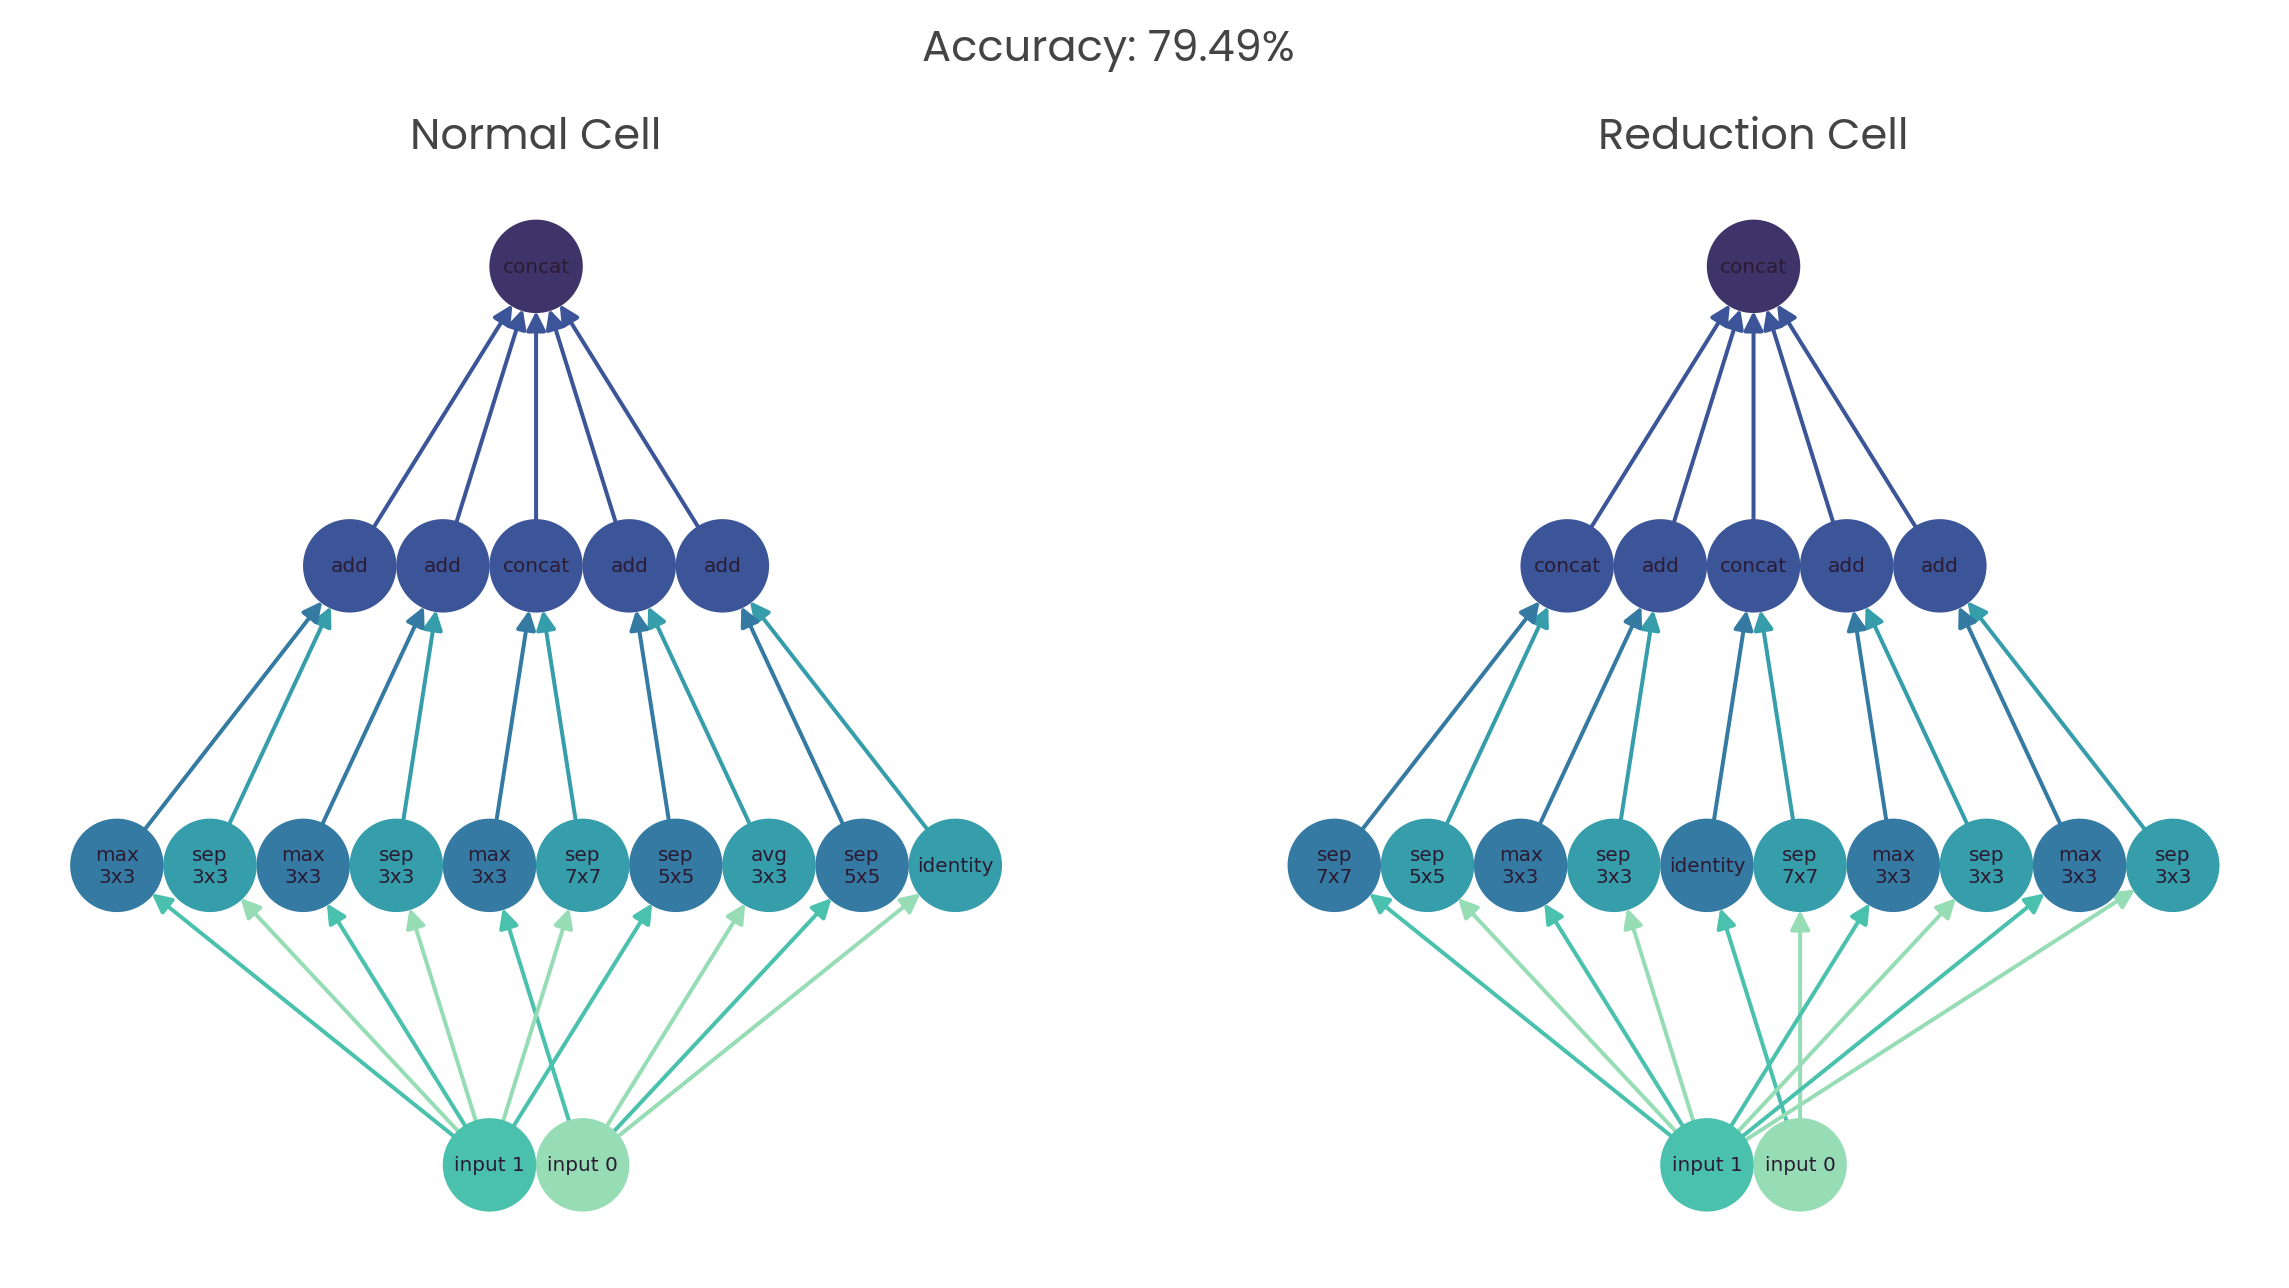

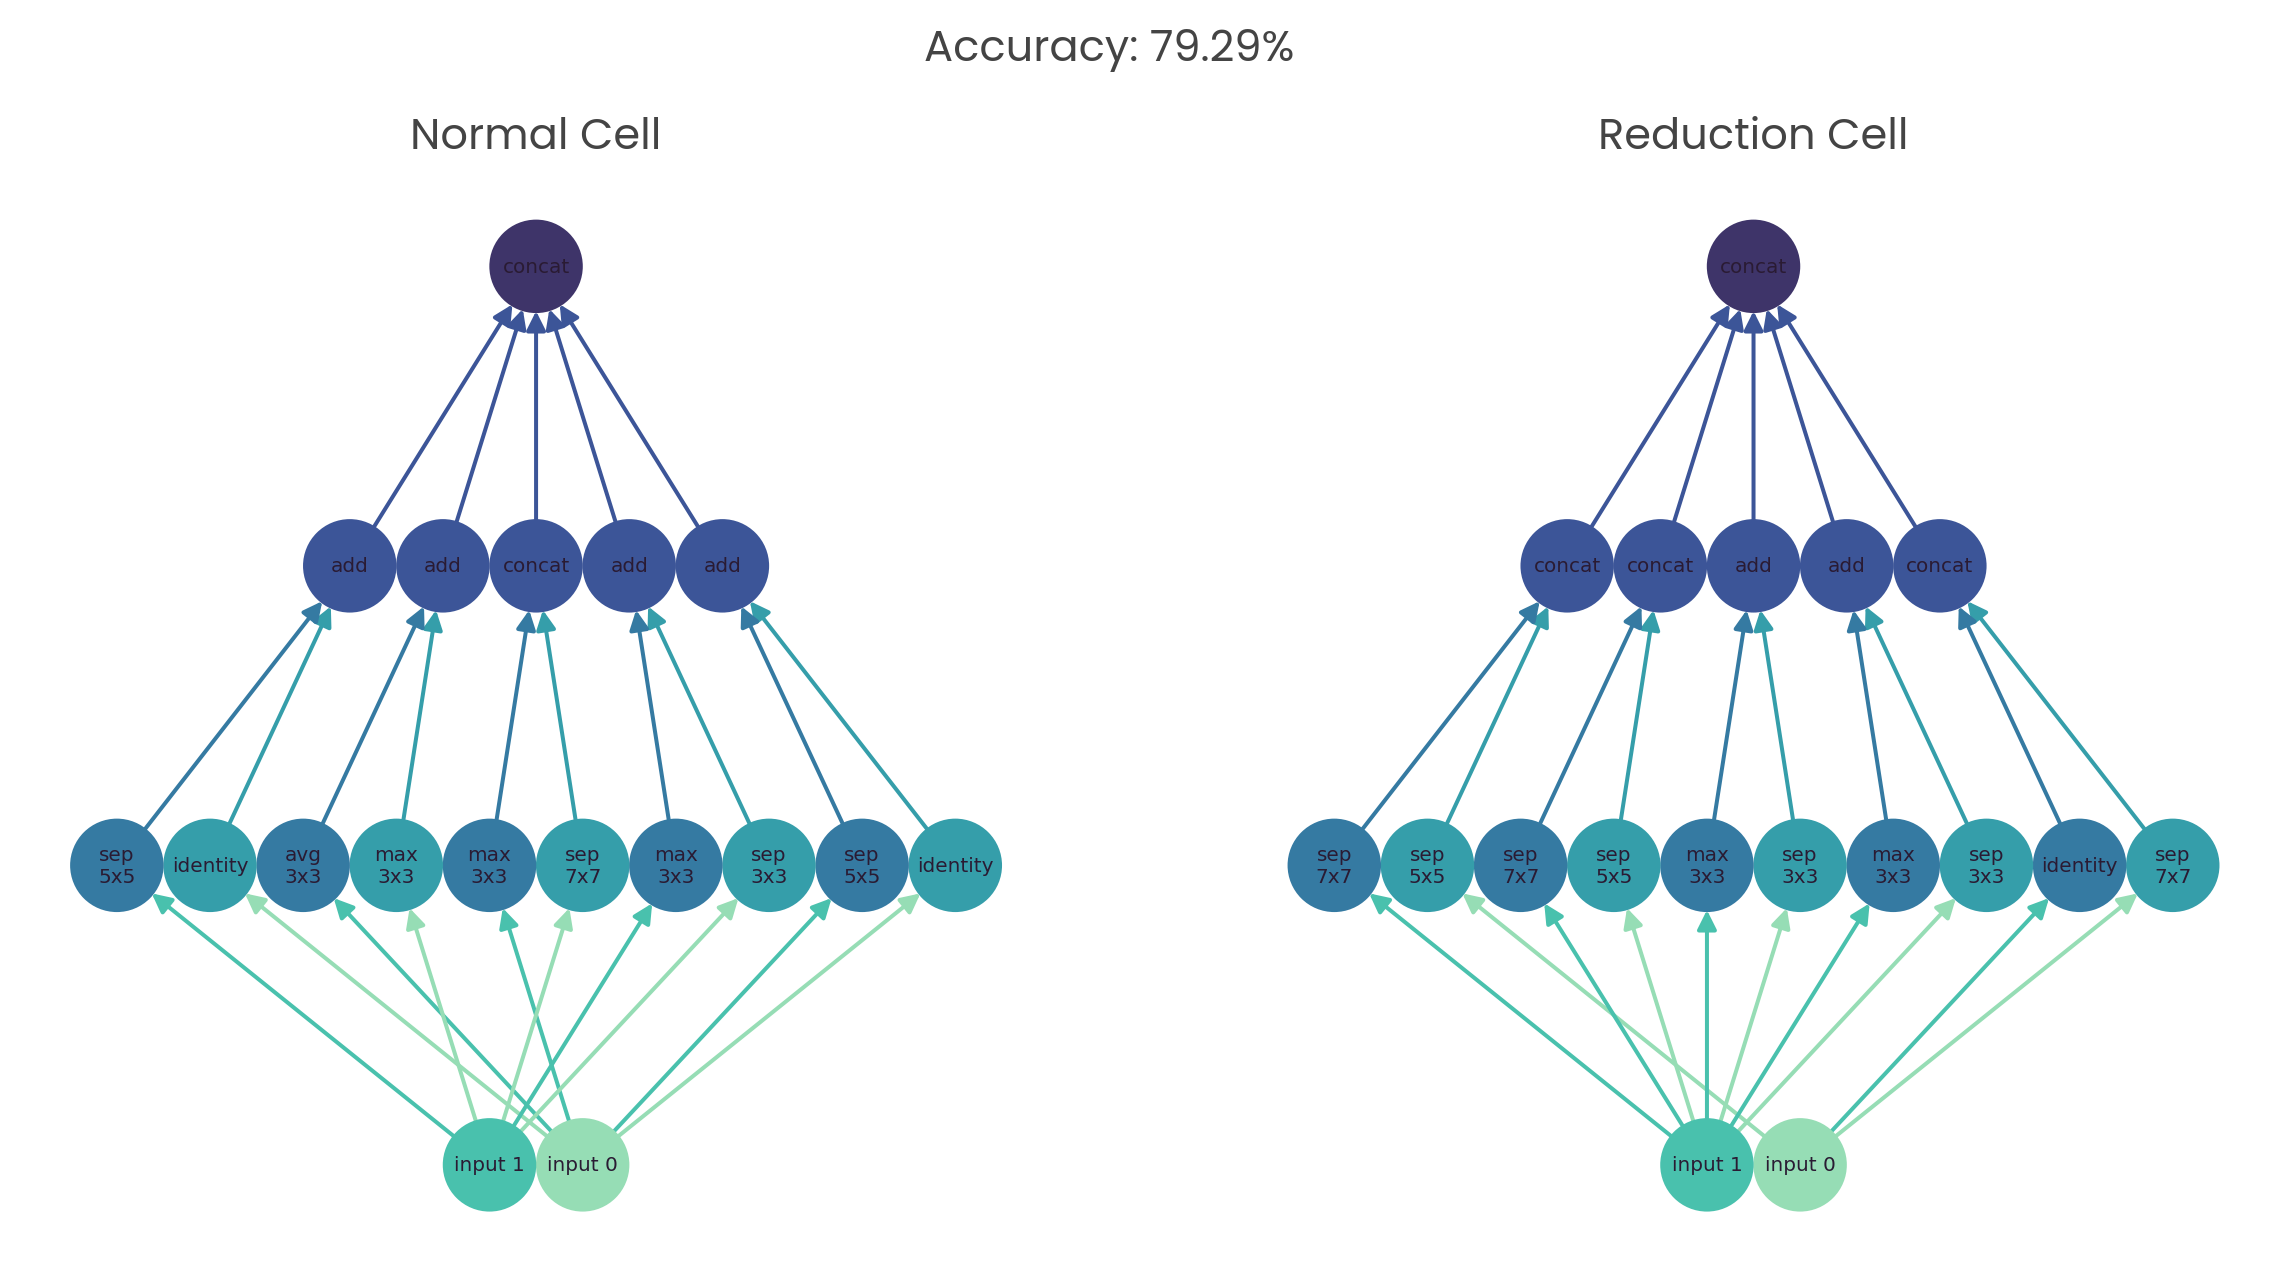

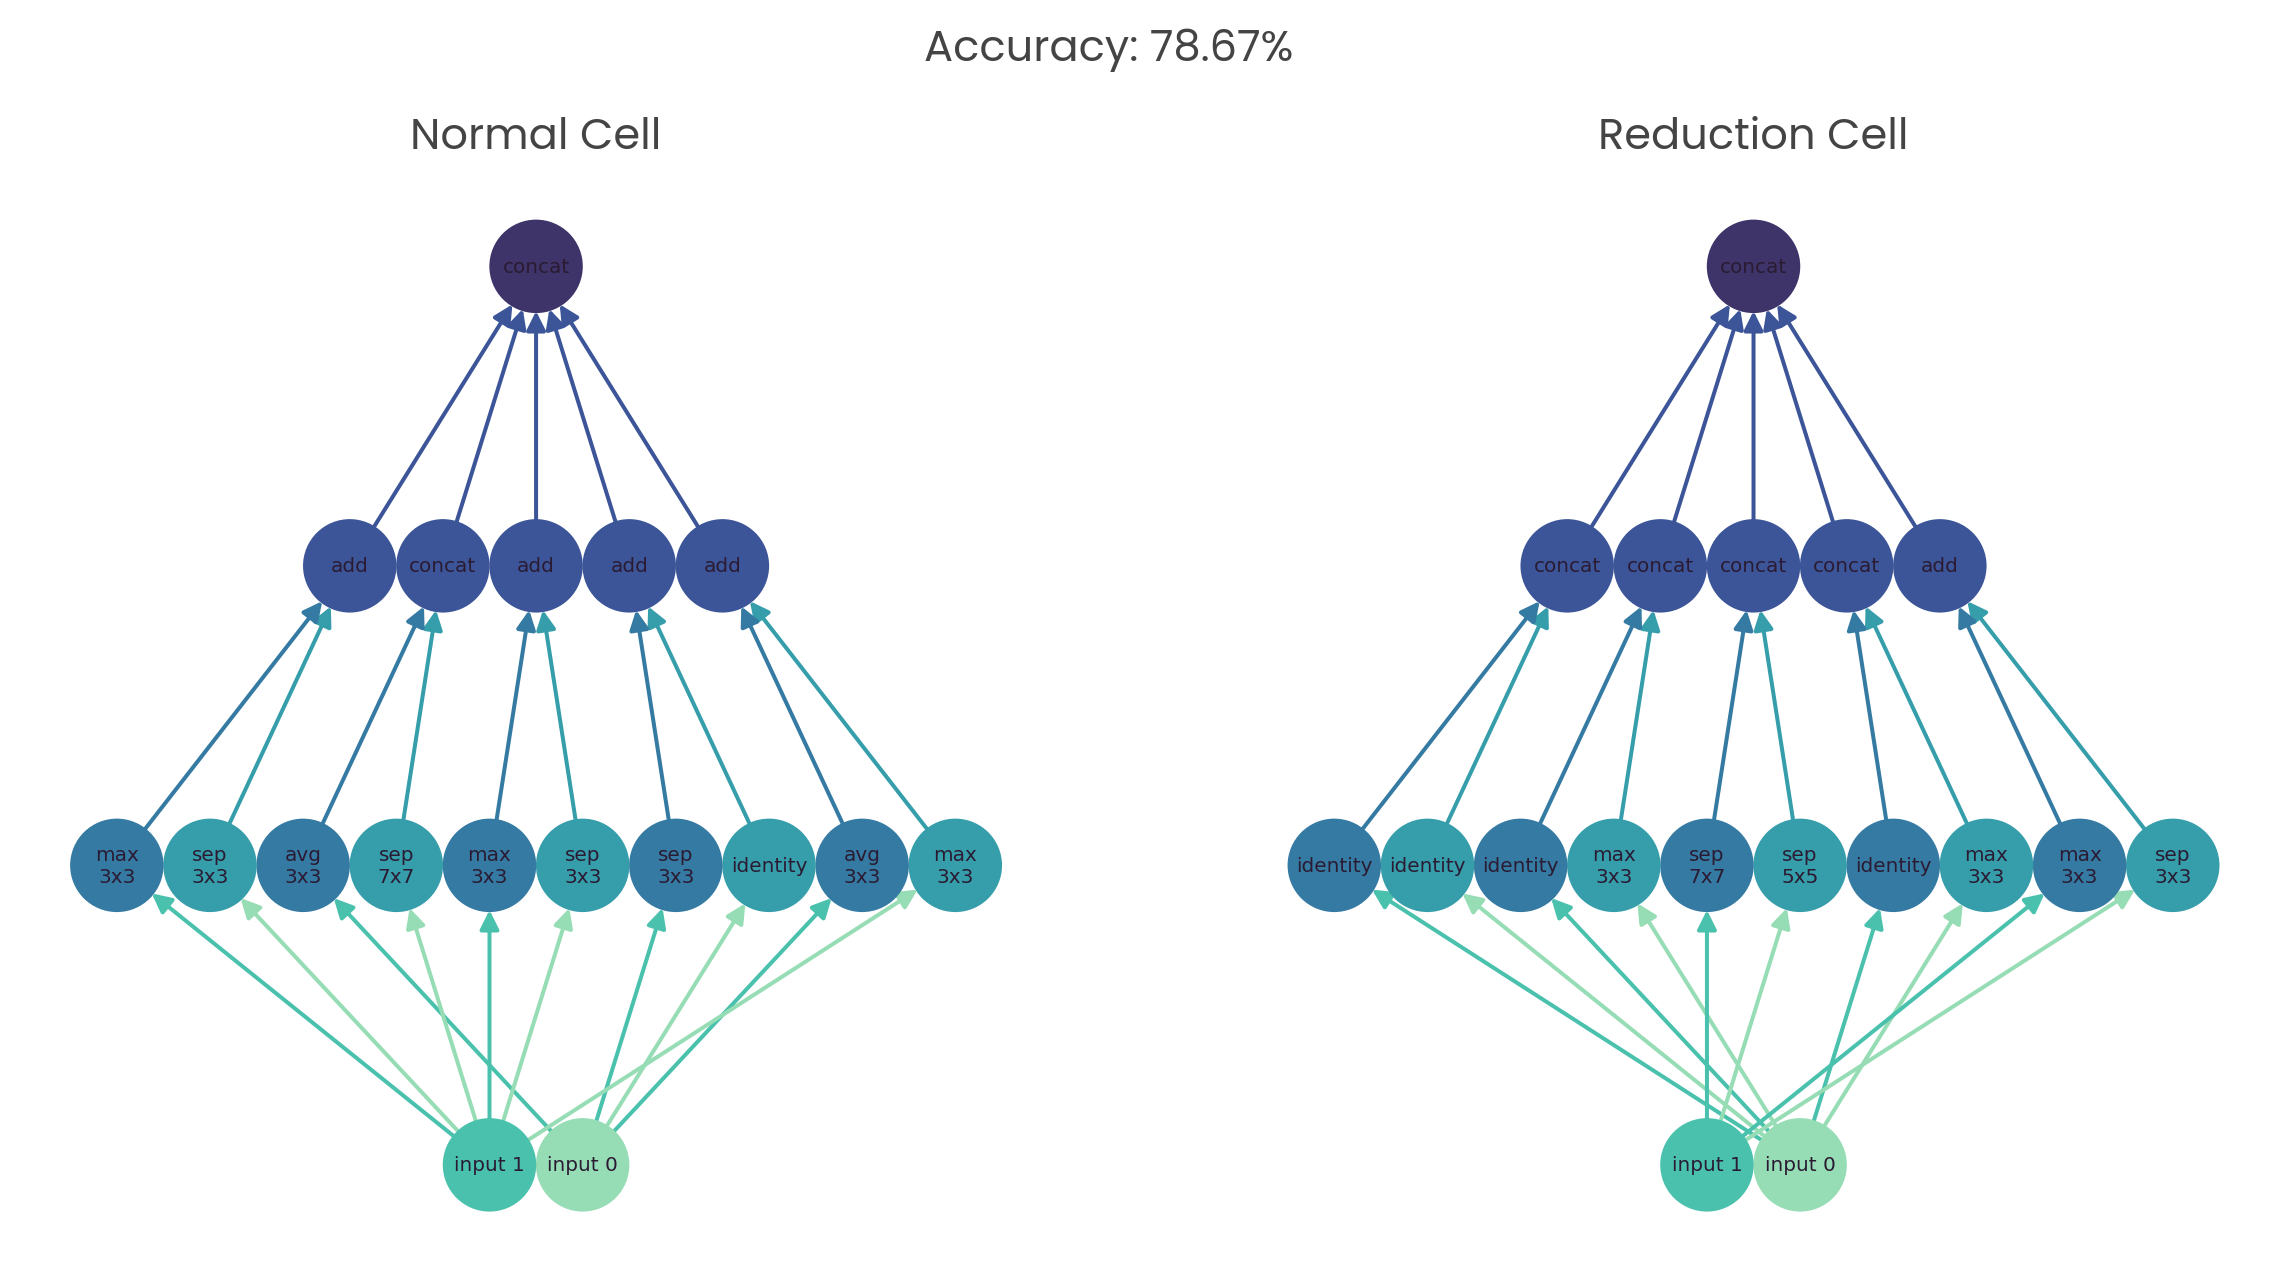

In [8]:
class VisualCell(object):
    def __init__(self, state_space, config) -> None:
        self.state_space = state_space
        self.config = config
        self.palette = seaborn.color_palette("mako_r", 7).as_hex()

        self.G = nx.DiGraph()
        self.labels = {
            'input 0': 'input 0',
            'input 1': 'input 1',
            'concat_blocks': 'concat'
        }
        self.colors = {
            'input 0': self.palette[0],
            'input 1': self.palette[1],
            'concat_blocks': self.palette[5]
        }

        # Add input nodes
        for input_state in self.state_space[0]['values']:
            self.G.add_node(
                self.input_label(input_state),
                layer=0
            )

        # Add primary and combination nodes for blocks
        for nid in range(sum(map(lambda s: s['count'], self.state_space))*3):
            self.G.add_node(
                nid,
                layer=self.get_layer_id(nid)
            )

        # Add block combination node
        self.G.add_node('concat_blocks', layer=3)

    def input_label(self, idx) -> str:
        return 'input {}'.format(idx)

    def primary_op_label(self, idx) -> str:
        return self.state_space[1]['values'][idx].replace('_', '\n')

    def combination_op_label(self, idx) -> str:
        return STATE_SPACE[2]['values'][idx]

    def get_node_id(self, bid, item):
        return bid*3 + item

    def get_layer_id(self, nid) -> int:
        return 2 if (nid+1)%3 ==0 else 1

    def compose_block(self, bid, block):
        input_0, input_1, op_1, op_2, comb = block
        nid_op_0, nid_op_1 = self.get_node_id(bid, 0), self.get_node_id(bid, 1)
        nid_comb = self.get_node_id(bid, 2)

        # Add primary styles
        # self.labels[nid_op_0] = self.state_space[1]['values'][op_1]
        self.labels[nid_op_0] = self.primary_op_label(op_1)
        self.labels[nid_op_1] = self.primary_op_label(op_2)

        self.colors[nid_op_0] = self.palette[2]
        self.colors[nid_op_1] = self.palette[3]

        # Add combination styles
        self.labels[nid_comb] = self.state_space[2]['values'][comb]
        self.colors[nid_comb] = self.palette[4]

        # Add incoming edges for primary operations
        self.G.add_edge(
            self.input_label(input_0),
            self.get_node_id(bid, 0),
            color=self.palette[0]
        )
        self.G.add_edge(
            self.input_label(input_1),
            self.get_node_id(bid, 1),
            color=self.palette[1]
        )

        # Add incoming edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 0),
            self.get_node_id(bid, 2),
            color=self.palette[2]
        )
        self.G.add_edge(
            self.get_node_id(bid, 1),
            self.get_node_id(bid, 2),
            color=self.palette[3]
        )

        # Add outgoing edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 2),
            'concat_blocks',
            color=self.palette[4]
        )
    
    def draw(self, ax):
        # Process cell
        for bid in range(self.config.shape[0]):
            self.compose_block(bid, self.config[bid])

        # Create a multipartite layout to arrange inputs, primary
        # and combination operations in their respective layers.
        pos = nx.multipartite_layout(
            self.G,
            subset_key='layer',
            align='horizontal'
        )

        # Configure edge colors
        edge_colors = nx.get_edge_attributes(self.G,'color').values()

        # Draw cell structure
        nx.draw(
            self.G,
            pos=pos,
            node_color=list(map(lambda l: self.colors[l], self.G.nodes)),
            edge_color=edge_colors,
            node_size=list(map(lambda _:500, self.G.nodes)),
            ax=ax,
        )

        # Label cell operations
        nx.draw_networkx_labels(
            self.G,
            pos=pos,
            labels=self.labels,
            font_size=5,
            font_color=self.palette[6],
            ax=ax
        )

def visualize_cell(ax, config, title='Cell'):
    ax.set_title(title)

    visual = VisualCell(STATE_SPACE, config)
    visual.draw(ax)

accuracies = list(map(lambda child: child.accuracy, controller.histories))
num_selected_trials = 3
visual_size = 5
best_configs = list(map(
    lambda idx: (controller.histories[idx].config, controller.histories[idx].accuracy),
    np.argsort(accuracies)[-num_selected_trials:][::-1]
))

for idx, (config, accuracy) in enumerate(best_configs):
    fig, axes = plt.subplots(1, 2, figsize=(2*visual_size, visual_size))
    visualize_cell(axes[0], config[0], 'Normal Cell')
    visualize_cell(axes[1], config[1], 'Reduction Cell')
    fig.suptitle('Accuracy: {:.2f}%'.format(accuracy*100))

best_configs